In [1]:
#D Marchfield 2024-05-23
#Animating particle node scatter plots to see evolution of particle positions during the simulation, using checkpoint and output files
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import mre.analyze
import mre.initialize
import os
import analysis_workflows
import re
mu0 = 4*np.pi*1e-7


In [ ]:

# sim_dir = f"/mnt/c/Users/bagaw/Desktop/MRE/two_particle/2024-06-27_125_particle_field_dependent_modulus_strain_strain_shearing_direction('x', 'y')_order_3_E_9000.0_nu_0.47_Bext_angle_0.0_gpu_True_profiling_stepsize_5.e-3/"
# sim_checkpoint_dir = sim_dir + "strain_0_strain_shearing_0.0_field_1_Bext_[0.01 0.   0.  ]/"
sim_dir = f"/mnt/c/Users/bagaw/Desktop/MRE/two_particle/2024-07-08_125_particle_hysteresis_order_5_E_9000.0_nu_0.47_Bext_angle_0.0_regular_vol_frac_0.2_stepsize_5.e-3/"
sim_dir = f"/mnt/c/Users/bagaw/Desktop/MRE/two_particle/2024-07-08_125_particle_hysteresis_order_3_E_9000.0_nu_0.47_Bext_angle_0.0_regular_anisotropic_noisy_vol_frac_0.03_starttime_16-30_stepsize_5.e-3/"
sim_dir = f"/mnt/c/Users/bagaw/Desktop/MRE/two_particle/2024-07-09_10_particle_hysteresis_order_3_E_9000.0_nu_0.47_Bext_angle_0.0_regular_anisotropic_noisy_vol_frac_0.03_starttime_11-42_stepsize_5.e-3/"
# sim_dir = f"/mnt/c/Users/bagaw/Desktop/MRE/two_particle/2024-07-01_125_particle_hysteresis_order_5_E_9000.0_nu_0.47_Bext_angle_0.0_gpu_True_regular_stepsize_5.e-3/"#f"/mnt/c/Users/bagaw/Desktop/MRE/two_particle/2024-05-09_125_particle_field_dependent_modulus_strain_strain_tension_direction('x', 'x')_order_3_E_9000.0_nu_0.47_Bext_angle_0.0_gpu_True_starttime_16-55_stepsize_5.e-3/"
sim_checkpoint_dir = sim_dir + "field_1_Bext_0.01/"#"strain_0_strain_tension_0.0_field_7_Bext_[0.07 0.   0.  ]/"

def read_in_simulation_parameters(sim_dir):
    initial_node_posns, node_mass, springs_var, elements, boundaries, particles, params, field_series, boundary_condition_series, sim_type = mre.initialize.read_init_file(sim_dir+'init.h5')
    for i in range(len(params)):
        if params.dtype.descr[i][0] == 'num_elements':
            num_elements = params[i]
            num_nodes = num_elements + 1
        if params.dtype.descr[i][0] == 'poisson_ratio':
            nu = params[i]
        if params.dtype.descr[i][0] == 'young_modulus':
            E = params[i]
        if params.dtype.descr[i][0] == 'kappa':
            kappa = params[i]
        if params.dtype.descr[i][0] == 'scaling_factor':
            beta = params[i]
        if params.dtype.descr[i][0] == 'element_length':
            l_e = params[i]
        if params.dtype.descr[i][0] == 'particle_mass':
            particle_mass = params[i]
        if params.dtype.descr[i][0] == 'particle_radius':
            particle_radius = params[i]
        if params.dtype.descr[i][0] == 'particle_Ms':
            Ms = params[i]
        if params.dtype.descr[i][0] == 'particle_chi':
            chi = params[i]
        if params.dtype.descr[i][0] == 'drag':
            drag = params[i]
        if params.dtype.descr[i][0] == 'characteristic_time':
            characteristic_time = params[i]

    dimensions = (l_e*np.max(initial_node_posns[:,0]),l_e*np.max(initial_node_posns[:,1]),l_e*np.max(initial_node_posns[:,2]))
    beta_i = beta/node_mass
    total_num_nodes = int(num_nodes[0]*num_nodes[1]*num_nodes[2])
    k = mre.initialize.get_spring_constants(E, l_e)
    k = np.array(k)

    return initial_node_posns, beta_i, springs_var, elements, boundaries, particles, num_nodes, total_num_nodes, E, nu, k, kappa, beta, l_e, particle_mass, particle_radius, Ms, chi, drag, characteristic_time, field_series, boundary_condition_series, sim_type, dimensions

def plot_particle_nodes(eq_node_posns,node_posns,particles,view,tag=""):
    Lx = eq_node_posns[:,0].max()
    Ly = eq_node_posns[:,1].max()
    Lz = eq_node_posns[:,2].max()
    xlabel = '\nX (l_e)'
    ylabel = '\nY (l_e)'
    zlabel = '\nZ (l_e)'
    axis_limit_max = np.max(np.array([Lx,Ly,Lz]))*1.1
    xlim = (-0.1,axis_limit_max)
    ylim = (-0.1,axis_limit_max)
    zlim = (-0.1,axis_limit_max)
    fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
    default_width,default_height = fig.get_size_inches()
    fig.set_size_inches(3*default_width,3*default_height)
    fig.set_dpi(200)
    particles = np.ravel(particles)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    if view == 'default':
        ax.scatter(node_posns[particles,0],node_posns[particles,1],node_posns[particles,2])
        mre.analyze.format_figure_3D(ax)
        if tag != "":
            ax.set_title(tag)
            tag = "_" + tag
    elif view == 'xy':
        ax.scatter(node_posns[particles,0],node_posns[particles,1],node_posns[particles,2],cmap='Blues',c=node_posns[particles,2])
        mre.analyze.format_figure_3D(ax)
        if tag != "":
            ax.set_title(tag)
        ax.view_init(90,-90,0)
        ax.set_zlabel('')
        ax.set_zticks([])
        ax.set_aspect('equal')
    elif view == 'xz':
        ax.scatter(node_posns[particles,0],node_posns[particles,1],node_posns[particles,2],cmap='Blues_r',c=node_posns[particles,1])
        mre.analyze.format_figure_3D(ax)
        if tag != "":
            ax.set_title(tag)
        ax.view_init(0,-90,0)
        ax.set_ylabel('')
        ax.set_yticks([])
        ax.set_aspect('equal')
    elif view == 'yz':
        ax.scatter(node_posns[particles,0],node_posns[particles,1],node_posns[particles,2],cmap='Blues',c=node_posns[particles,0])
        mre.analyze.format_figure_3D(ax)
        if tag != "":
            ax.set_title(tag)
        ax.view_init(0,0,0)
        ax.set_xlabel('')
        ax.set_xticks([])
        ax.set_aspect('equal')
    return fig, ax

def animate_particle_nodes(sim_dir,sim_checkpoint_dir,view,output_file_number,output_dir,tag=""):
    """Animate a scatter plot showing the nodes making up the particles using output and checkpoint files."""
    #Do basic read in
    eq_node_posns, mass, springs, elements, boundaries, particles, parameters, field_series, boundary_condition_series, sim_type = mre.initialize.read_init_file(sim_dir + 'init.h5')
    #either have user provide the directory of the specific simulation step, or else somehow specify it (the applied strain and the applied field)
    if output_file_number == 0:
        solution = eq_node_posns
        # _, _, boundary_conditions, _ = mre.initialize.read_output_file(sim_dir+f'output_{output_file_number}.h5')
    else:
        node_posns, _, boundary_conditions, _ = mre.initialize.read_output_file(sim_dir+f'output_{output_file_number-1}.h5')
        solution = node_posns
    # boundary_conditions = mre.initialize.format_boundary_conditions(boundary_conditions)
    num_checkpoint_files = mre.analyze.get_num_named_files(sim_checkpoint_dir,'checkpoint')
    num_output_files = mre.analyze.get_num_named_files(sim_checkpoint_dir,'output')
    #if an extension directory exists, get that too
    if os.path.isdir(sim_checkpoint_dir[:-1] + '_extension/'):
        num_extra_checkpoint_files = mre.analyze.get_num_named_files(sim_checkpoint_dir[:-1] + '_extension/','checkpoint')
    else:
        num_extra_checkpoint_files = 0
    #then read in the necessary first file (if doing a single simulation step, though it is also possible to animate a simulation across multiple steps)
    #find the right output file number to read in and construct the starting frame
    #construct the first figure and keep the handle to the figure and axes, taking into account the user desired view angle
    #use the matplotlib.animation.FuncAnimation class
    #make sure to save the animation
    print(f'total number of frames is {num_checkpoint_files + num_extra_checkpoint_files}')
    num_nodes = eq_node_posns.shape[0]
    node_posns = solution[:3*num_nodes].reshape((num_nodes,3))
    fig, ax = plot_particle_nodes(eq_node_posns,node_posns,particles,view,tag)
    fig_width,fig_height = fig.get_size_inches()*fig.get_dpi()
    print(fig_width,fig_height)
    frame_annotation = ax.annotate('frame:0',xy=(fig_width*0.8,fig_height*0.8),xycoords='figure pixels')
    particles = np.ravel(particles)
    # try:
        # print(ax.get_children()[0])
        # data_to_rgba_converter = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=np.min(node_posns[particles,2]),vmax=np.max(node_posns[particles,2])),cmap='Blues')
        # print(data_to_rgba_converter)
        # print(node_posns[particles,2].shape)
        # data_to_rgba_converter = matplotlib.cm.ScalarMappable(cmap='Blues')
        # rgba_colors = data_to_rgba_converter.to_rgba(node_posns[particles,2])
        # print(rgba_colors)
        # print(rgba_colors.shape)
        # print(ax.get_children()[0].get_facecolor())
        # print(ax.get_children()[0].get_facecolor().shape)
        # ax.get_children()[0]._facecolor3d(rgba_colors)
        # ax.get_children()[0].set_color(rgba_colors)
        # ax.get_children()[0].set_array(rgba_colors)
        # shifted_data = node_posns[particles,2] - np.min(node_posns[particles,2])
        # normalized_shifted_data = shifted_data/np.max(shifted_data)
        # print(normalized_shifted_data)
        # print(np.min(normalized_shifted_data),np.max(normalized_shifted_data))
        # ax.get_children()[0].set_array(normalized_shifted_data)
    # except:
    #     raise
    OUTPUT_FILE_OFFSET = 1
    if os.path.isfile(sim_dir+f'output_{output_file_number}.h5'):
        OUTPUT_FILE_OFFSET += 1
    # if output_file_number != 0:
    #     OUTPUT_FILE_OFFSET += 1
    print('entering FuncAnimation call')
    ani = animation.FuncAnimation(fig=fig,func=update_scatter,frames=np.arange(num_checkpoint_files+num_extra_checkpoint_files+OUTPUT_FILE_OFFSET),interval=500,fargs=(ax,view,sim_checkpoint_dir,num_checkpoint_files,num_extra_checkpoint_files,particles,frame_annotation,output_file_number,OUTPUT_FILE_OFFSET))
    print('returned from FuncAnimation call')
    plt.show()
    return fig, ax, ani

def update_scatter(frame,*fargs):
    """Update an existing 3D scatter plot."""
    # print(f'frame:{frame}')
    ax = fargs[0]
    view = fargs[1]
    checkpoint_dir = fargs[2]
    num_checkpoint_files = fargs[3]
    num_extra_checkpoint_files = fargs[4]
    particles = fargs[5]
    frame_annotation = fargs[6]
    output_file_number = fargs[7]
    OUTPUT_FILE_OFFSET = fargs[8]
    #read in the checkpoint file based on the frame number (checking which directory based on the frame number and the num_checkpoint_files and num_extra_checkpoint_files values)
    if frame == 0:
        if output_file_number == 0:
            node_posns, _, _, _, _, _, _, _, _, _ = mre.initialize.read_init_file(sim_dir + 'init.h5')
        else:
            node_posns, _, _, _ = mre.initialize.read_output_file(sim_dir+f'output_{output_file_number-1}.h5')
    elif frame < num_checkpoint_files + 1:
        solution, _, _, _, _ = mre.initialize.read_checkpoint_file(checkpoint_dir + f'checkpoint{frame-1}.h5')
        num_nodes = int(np.round(solution.shape[0]/6))
        node_posns = solution[:3*num_nodes].reshape((num_nodes,3))
    elif frame < num_checkpoint_files + num_extra_checkpoint_files + 1:
        solution, _, _, _, _ = mre.initialize.read_checkpoint_file(checkpoint_dir[:-1] + '_extension/' + f'checkpoint{frame-1}.h5')
        num_nodes = int(np.round(solution.shape[0]/6))
        node_posns = solution[:3*num_nodes].reshape((num_nodes,3))
    else:
        node_posns, _, _, _ = mre.initialize.read_output_file(sim_dir+f'output_{output_file_number}.h5')
    #reshape the positions variable and update the scatter plot data with set_offsets
    
    new_data = node_posns[particles,:]
    axes_children = ax.get_children()
    scatter_artist = axes_children[0]
    scatter_artist._offsets3d = (new_data[:,0],new_data[:,1],new_data[:,2])
    if view != 'default':
        if view == 'xy':
            new_colors = new_data[:,2]
            data_to_rgba_converter = matplotlib.cm.ScalarMappable(norm=None,cmap='Blues')
        elif view == 'xz':
            new_colors = new_data[:,1]
            data_to_rgba_converter = matplotlib.cm.ScalarMappable(norm=None,cmap='Blues_r')
        elif view == 'yz':
            new_colors = new_data[:,0]
            data_to_rgba_converter = matplotlib.cm.ScalarMappable(norm=None,cmap='Blues')
        rgba_colors = data_to_rgba_converter.to_rgba(new_colors)
        scatter_artist.set_color(rgba_colors)
    # scatter_artist.set_3d_properties(new_data[:,2],'z')
    # print('updating color depth')
    # scatter_artist.set(facecolor=new_colors)
    frame_annotation.set_text(f'frame:{frame}')
    if view == 'default':
        pass

    return scatter_artist,

def animate_views(sim_dir,sim_checkpoint_dir,output_file_number):
    """Generate and save an appropriately named .gif file animating the start, intermediate, and end points of a simulation step from 3 views"""
    views = ['xy']#['xy','xz','yz']#['xy','yz']#
    for view in views:
        fig, ax, ani = animate_particle_nodes(sim_dir,sim_checkpoint_dir,view,output_file_number,output_dir="",tag="")
        ani.save(filename=sim_checkpoint_dir[:-1]+f'_{view}.gif',writer="ffmpeg")

def animate_field_steps(sim_dir):
    """Generate a series of .gif files animating the particle configurations of a simulation at each simulation step"""
    subfolders = [f.path + '/' for f in os.scandir(sim_dir) if f.is_dir()]
    output_file_number = 0
    for checkpoint_dir in subfolders:
        if not 'figures' in checkpoint_dir:
            # print(f'checkpoint_directory:{checkpoint_dir} and output_file_number: {output_file_number}')
            if output_file_number == 0:
                animate_views(sim_dir,checkpoint_dir,output_file_number)
            output_file_number += 1

sim_dir = f"/mnt/c/Users/bagaw/Desktop/MRE/two_particle/2024-07-10_20_particle_field_dependent_modulus_strain_strain_shearing_direction('x', 'y')_order_5_E_9000.0_nu_0.47_Bext_angle_0.0_regular_anisotropic_noisy_vol_frac_0.1_starttime_12-19_stepsize_1.e-3/"
# animate_field_steps(sim_dir)

# fig, ax, ani = animate_particle_nodes(sim_dir,sim_checkpoint_dir,view='xy',output_file_number=0,output_dir="",tag="")
# ani.save(filename=sim_dir+'1e-1mT_field_xy.gif',writer="ffmpeg")
# ani.save(filename=sim_dir+'test_animation_hysteresis_low_field_v3.webp',writer="pillow")
# ani.save(filename=sim_dir+'10mT_field_xy.gif',writer="ffmpeg")


total number of frames is 28
[<mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fa2c1db0880>, <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fa2c1db0b20>, <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fa2c1db0d30>, <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fa2c1db0e20>, <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fa2c1db1450>, <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fa2c1db17e0>, <matplotlib.spines.Spine object at 0x7fa2c4353100>, <matplotlib.spines.Spine object at 0x7fa2c4353010>, <matplotlib.spines.Spine object at 0x7fa2c4352f20>, <matplotlib.spines.Spine object at 0x7fa2c4352e30>, <mpl_toolkits.mplot3d.axis3d.XAxis object at 0x7fa2c43530d0>, <mpl_toolkits.mplot3d.axis3d.YAxis object at 0x7fa3ec5f76a0>, <mpl_toolkits.mplot3d.axis3d.ZAxis object at 0x7fa3ec6373a0>, Text(0.5, 0.92, ''), Text(0.0, 1.0, ''), Text(1.0, 1.0, ''), <matplotlib.patches.Rectangle object at 0x7fa3ec68a350>]
2560.0 1920.0
entering Fun

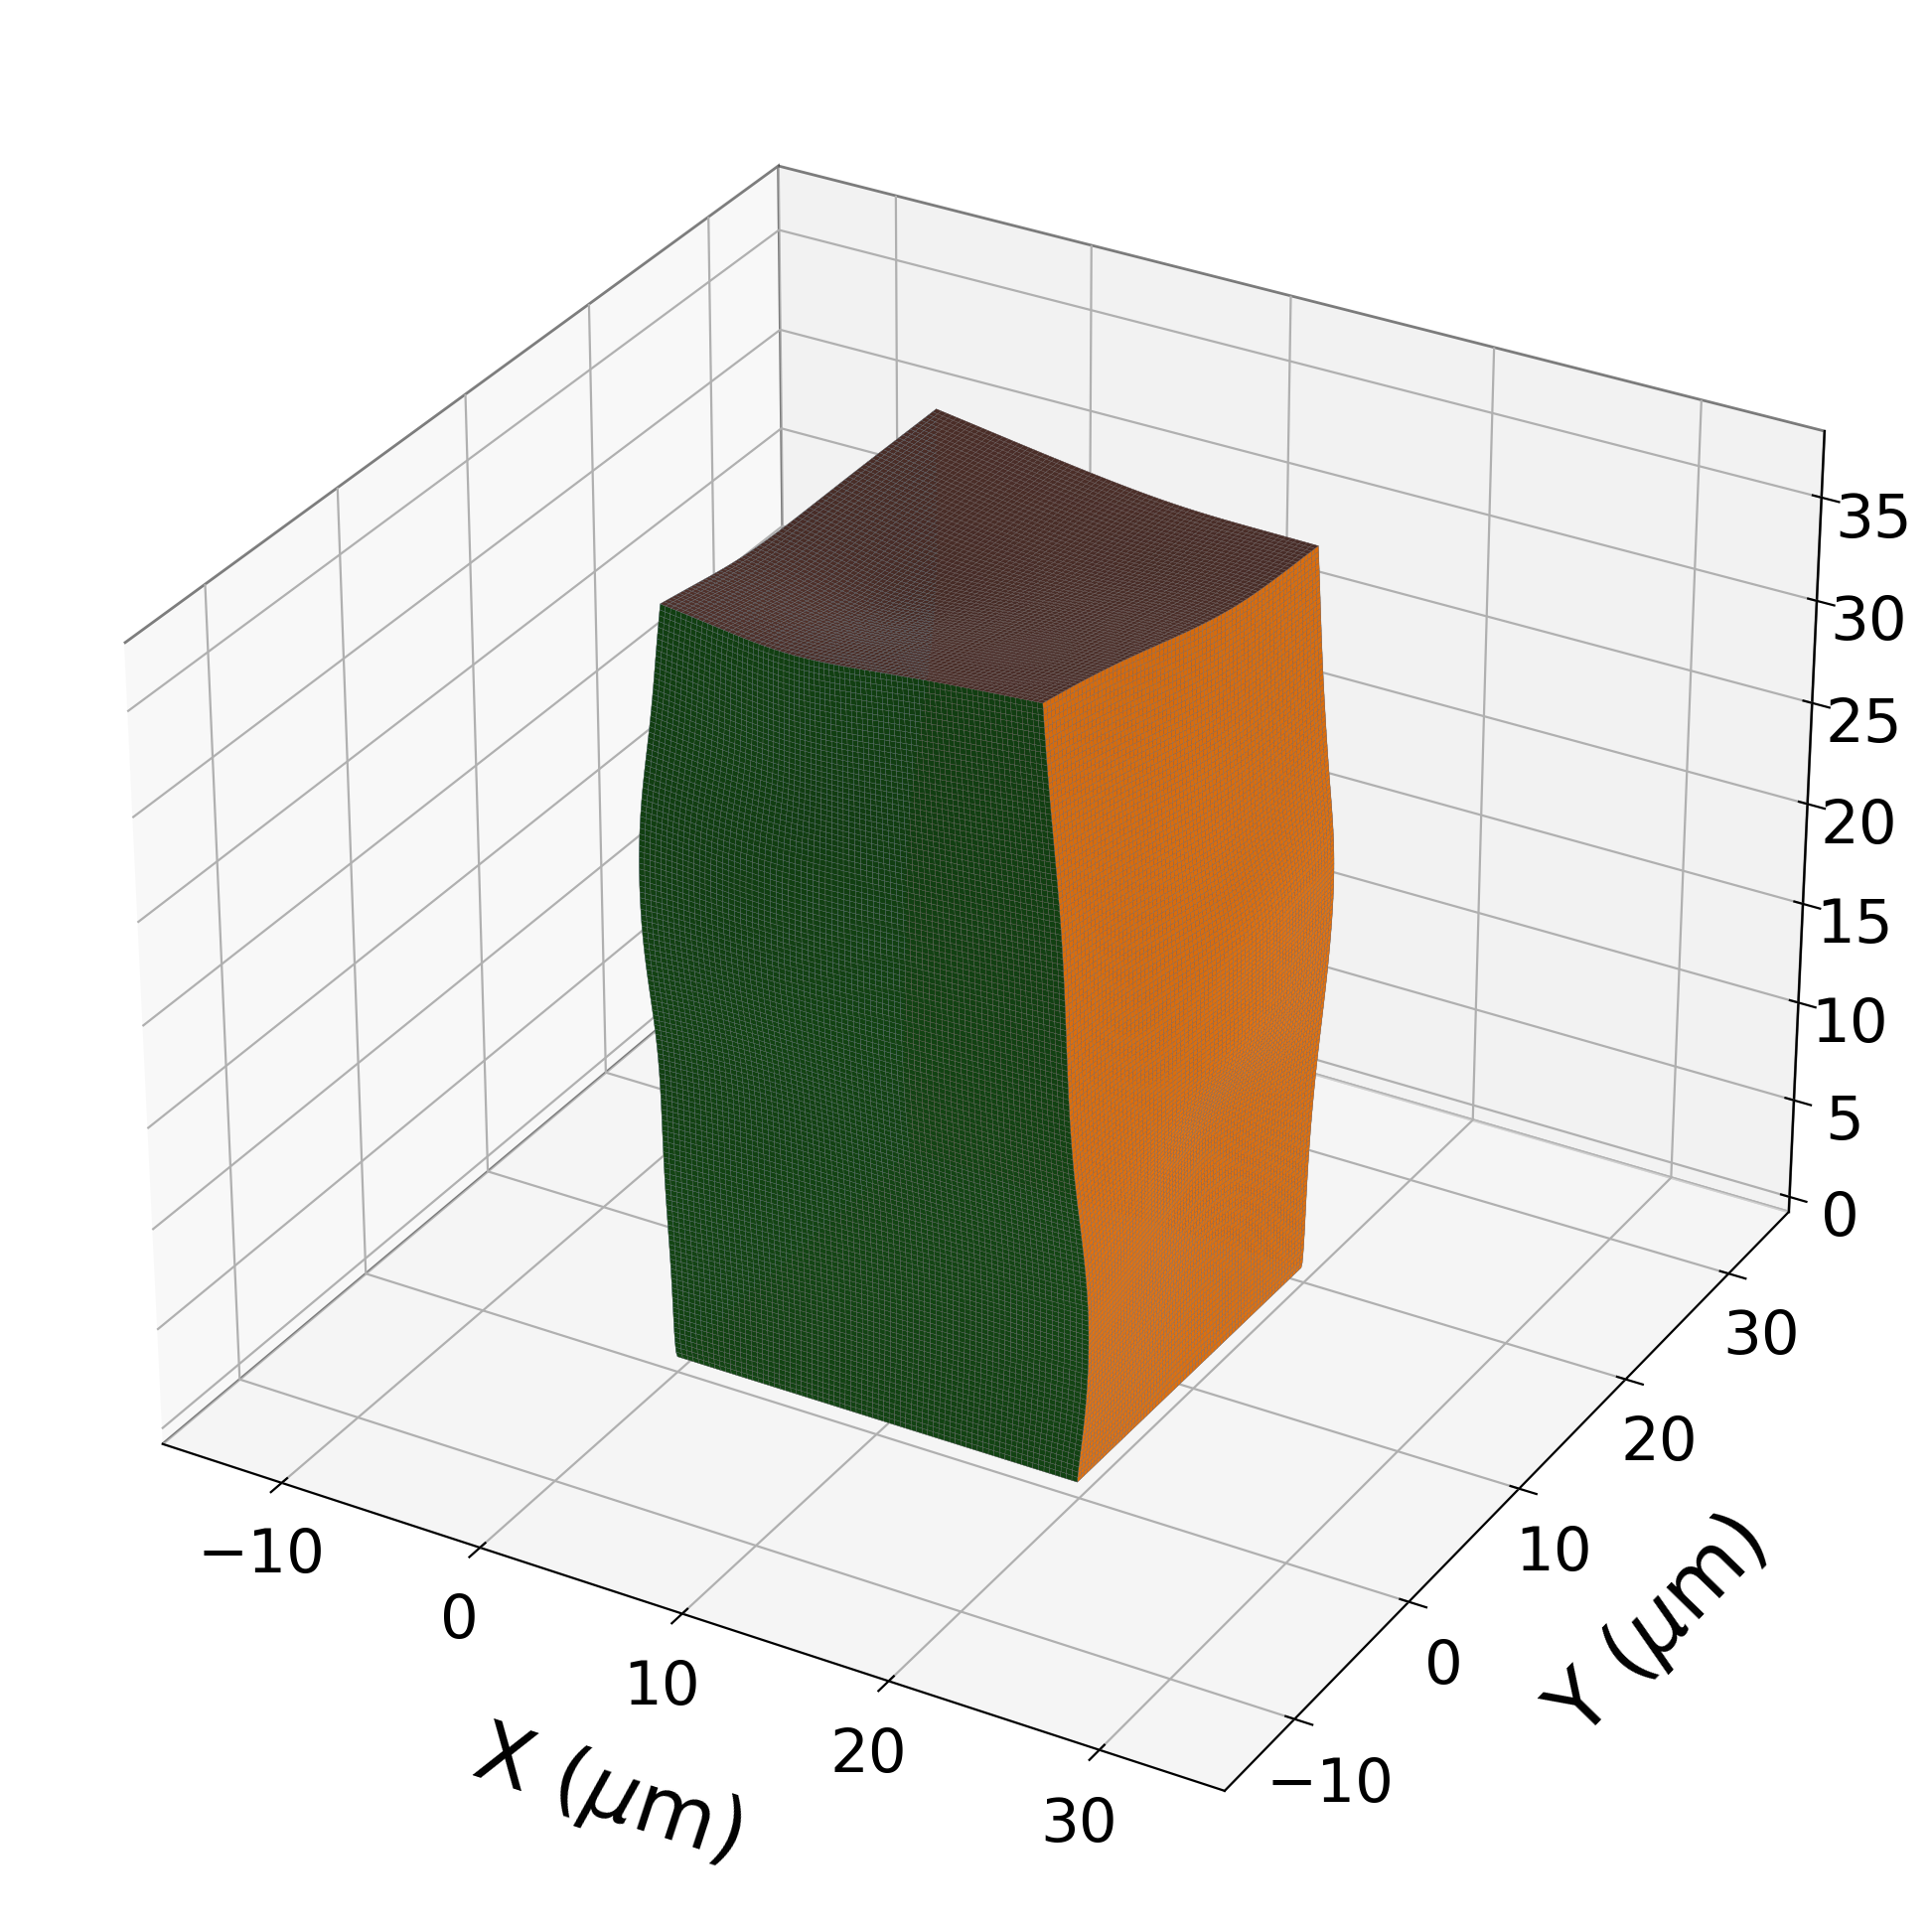

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '2560x1920', '-pix_fmt', 'rgba', '-r', '2.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/mnt/c/Users/bagaw/Desktop/testing_outer_surface_twist.mp4']' returned non-zero exit status 255.

In [ ]:
def animate_outer_surf(sim_dir,sim_checkpoint_dir,output_dir,tag=""):
    """Animate a scatter plot showing the nodes making up the particles using output and checkpoint files."""
    #Do basic read in
    initial_node_posns, beta_i, springs_var, elements, boundaries, particles, num_nodes, total_num_nodes, E, nu, k, kappa, beta, l_e, particle_mass, particle_radius, Ms, chi, drag, characteristic_time, field_series, boundary_condition_series, sim_type, dimensions = read_in_simulation_parameters(sim_dir)
    #either have user provide the directory of the specific simulation step, or else somehow specify it (the applied strain and the applied field)
    solution, _, applied_field, boundary_conditions, count = mre.initialize.read_checkpoint_file(sim_checkpoint_dir + 'checkpoint0.h5')
    boundary_conditions = mre.initialize.format_boundary_conditions(boundary_conditions)
    num_checkpoint_files = mre.analyze.get_num_named_files(sim_checkpoint_dir,'checkpoint')
    num_output_files = mre.analyze.get_num_named_files(sim_checkpoint_dir,'output')
    #if an extension directory exists, get that too
    if os.path.isdir(sim_checkpoint_dir[:-1] + '_extension/'):
        num_extra_checkpoint_files = mre.analyze.get_num_named_files(sim_checkpoint_dir[:-1] + '_extension/','checkpoint')
    else:
        num_extra_checkpoint_files = 0
    #then read in the necessary first file (if doing a single simulation step, though it is also possible to animate a simulation across multiple steps)
    #find the right output file number to read in and construct the starting frame
    #construct the first figure and keep the handle to the figure and axes, taking into account the user desired view angle
    #use the matplotlib.animation.FuncAnimation class
    #make sure to save the animation
    print(f'total number of frames is {num_checkpoint_files + num_extra_checkpoint_files}')
    num_nodes = initial_node_posns.shape[0]
    node_posns = solution[:3*num_nodes].reshape((num_nodes,3))
    fig, ax = mre.analyze.plot_outer_surfaces_si(initial_node_posns,node_posns,l_e,output_dir,tag=f"bc_{boundary_conditions[2]}_field_{np.round(mu0*applied_field,decimals=4)}",animation_flag=True)
    print(ax.get_children())
    fig_width,fig_height = fig.get_size_inches()*fig.get_dpi()
    print(fig_width,fig_height)
    frame_annotation = ax.annotate('frame:0',xy=(fig_width*0.8,fig_height*0.8),xycoords='figure pixels')

    Lx = initial_node_posns[:,0].max()
    Ly = initial_node_posns[:,1].max()
    Lz = initial_node_posns[:,2].max()
    normalized_dimensions = [Lx,Ly,Lz]
    # print(Lx,Ly,Lz)

    # xposn_3D, yposn_3D, zposn_3D = mre.analyze.get_component_3D_arrays(node_posns,(int(Lx+1),int(Ly+1),int(Lz+1)))
    # xposn_3D *= l_e*1e6
    # yposn_3D *= l_e*1e6
    # zposn_3D *= l_e*1e6
    # layers = (0,Lx,0,Ly,0,Lz)
    # Lx *= l_e*1e6
    # Ly *= l_e*1e6
    # Lz *= l_e*1e6
    
    # for cut_type_index in range(3):
    #     for i in range(2):
    #         idx = int(layers[2*cut_type_index+i])
    #         xvar, yvar, zvar = mre.analyze.get_cut_type_posn_variables(cut_type_index,idx,xposn_3D,yposn_3D,zposn_3D)
    #         stacked_posns = np.stack([xvar,yvar,zvar],axis=-1)
    #         print('stacked_posns:',stacked_posns)
    #         vertices = np.reshape(stacked_posns,(xvar.shape[0]*xvar.shape[1],3),order='C')
    #         print('vertices:',vertices)
    #         axes_children = ax.get_children()
    print('entering FuncAnimation call')
    print(fig.canvas)
    ani = animation.FuncAnimation(fig=fig,func=update_surf,frames=np.arange(num_checkpoint_files+num_extra_checkpoint_files),interval=500,fargs=(ax,normalized_dimensions,sim_checkpoint_dir,num_checkpoint_files,num_extra_checkpoint_files,l_e,frame_annotation,fig))
    print('returned from FuncAnimation call')
    plt.show()
    return fig, ax, ani

def update_surf(frame,*fargs):
    """Update an existing 3D surf plot."""
    # print(f'frame:{frame}')
    ax = fargs[0]
    dimensions = fargs[1]
    checkpoint_dir = fargs[2]
    num_checkpoint_files = fargs[3]
    num_extra_checkpoint_files = fargs[4]
    l_e = fargs[5]
    frame_annotation = fargs[6]
    fig = fargs[7]
    #read in the checkpoint file based on the frame number (checking which directory based on the frame number and the num_checkpoint_files and num_extra_checkpoint_files values)
    if frame < num_checkpoint_files:
        solution, _, _, _, _ = mre.initialize.read_checkpoint_file(checkpoint_dir + f'checkpoint{frame}.h5')
    else:
        solution, _, _, _, _ = mre.initialize.read_checkpoint_file(checkpoint_dir[:-1] + '_extension/' + f'checkpoint{frame}.h5')
    Lx, Ly, Lz = dimensions
    #reshape the positions variable and update the scatter plot data with set_verts
    num_nodes = int(np.round(solution.shape[0]/6))
    node_posns = solution[:3*num_nodes].reshape((num_nodes,3))

    xposn_3D, yposn_3D, zposn_3D = mre.analyze.get_component_3D_arrays(node_posns,(int(Lx+1),int(Ly+1),int(Lz+1)))
    xposn_3D *= l_e*1e6
    yposn_3D *= l_e*1e6
    zposn_3D *= l_e*1e6
    layers = (0,Lx,0,Ly,0,Lz)
    artist_list = []
    #delete the old surfaces and plot new ones
    ax.clear()

    # for cut_type_index in range(3):
    #     for i in range(2):
    #         axes_children = ax.get_children()
    #         surf_artist = axes_children[2*cut_type_index+i]
    #         artist_list.append(surf_artist)
    # for i in range(len(artist_list)):
    #     artist_list[i].remove()
    artist_list = []
    for cut_type_index in range(3):
        for i in range(2):
            idx = int(layers[2*cut_type_index+i])
            xvar, yvar, zvar = mre.analyze.get_cut_type_posn_variables(cut_type_index,idx,xposn_3D,yposn_3D,zposn_3D)
            # stacked_posns = np.stack([xvar,yvar,zvar],axis=-1)
            # vertices = np.reshape(stacked_posns,(xvar.shape[0]*xvar.shape[1],3),order='C')
            # surf_artist.set_verts(vertices)
            surf_artist = ax.plot_surface(xvar,yvar,zvar,rstride=1,cstride=1,edgecolor='gray')
            artist_list.append(surf_artist)
    # print('updating color depth')
    # scatter_artist.set(facecolor=new_colors)
    # frame_annotation.set_text(f'frame:{frame}')

    return surf_artist,



output_dir = '/mnt/c/Users/bagaw/Desktop/'
sim_dir = f"/mnt/c/Users/bagaw/Desktop/MRE/two_particle/2025-03-31_10_particle_field_dependent_modulus_strain_magnetostriction_direction('z', 'z')_order_5_E_9.e+03_nu_0.47_Bext_angles_0.0_0.0_by_hand_vol_frac_9.21e-3_starttime_13-18_stepsize_5.e-3/"
sim_checkpoint_dir = sim_dir + "strain_magnetostriction_0_0.e+00_field_3_Bext_[0.   0.   0.03]/"
fig, ax, ani = animate_outer_surf(sim_dir,sim_checkpoint_dir,output_dir="",tag="")
# ani.save(filename=sim_dir+'test_animation_outer_surfaces_hysteresis_low_field.webp',writer="pillow")
# ani.save(filename=sim_dir+'test_animation_outer_surfaces_hysteresis_low_field.gif',writer="ffmpeg")
ani.save(filename=output_dir+'testing_outer_surface_twist.mp4')

In [40]:
#2025-04-012 updating animations using scatter plots to show nodes belonging to particles, where color shade gives depth information

#using some helpful post from StackOverflow "How to correctly sort a string with a number inside? [duplicate]"
#stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implmentation in the comments)
    '''
    return [atoi(c) for c in re.split(r'(\d+)',text)]

def plot_particle_nodes(eq_node_posns,node_posns,particles,view,tag=""):
    Lx = eq_node_posns[:,0].max()
    Ly = eq_node_posns[:,1].max()
    Lz = eq_node_posns[:,2].max()
    xlabel = '\nX (l_e)'
    ylabel = '\nY (l_e)'
    zlabel = '\nZ (l_e)'
    axis_limit_max = np.max(np.array([Lx,Ly,Lz]))*1.1
    xlim = (-0.1,axis_limit_max)
    ylim = (-0.1,axis_limit_max)
    zlim = (-0.1,axis_limit_max)
    fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
    default_width,default_height = fig.get_size_inches()
    fig.set_size_inches(2*default_width,2*default_height)
    fig.set_dpi(200)
    particles = np.ravel(particles)

    # ax.set_xlabel(xlabel)
    # ax.set_ylabel(ylabel)
    # ax.set_zlabel(zlabel)
    # ax.set_xlim(xlim)
    # ax.set_ylim(ylim)
    # ax.set_zlim(zlim)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    if view == 'default':
        x = 2*Lx
        y = -2*Ly
        z = 2*Lz
        print(np.shape(np.transpose(np.array([node_posns[particles,0]-x,node_posns[particles,1]-y,node_posns[particles,2]-z]))))
        distance = np.linalg.norm(np.transpose(np.array([node_posns[particles,0]-x,node_posns[particles,1]-y,node_posns[particles,2]-z])),axis=1)
        print(np.shape(distance))
        ax.scatter(node_posns[particles,0],node_posns[particles,1],node_posns[particles,2],cmap='Blues_r',c=distance)
        mre.analyze.format_figure_3D(ax)
        if tag != "":
            ax.set_title(tag)
            tag = "_" + tag
    elif view == 'xy':
        ax.scatter(node_posns[particles,0],node_posns[particles,1],node_posns[particles,2],cmap='Blues',c=node_posns[particles,2])
        mre.analyze.format_figure_3D(ax)
        if tag != "":
            ax.set_title(tag)
        ax.view_init(90,-90,0)
        ax.set_zlabel('')
        ax.set_zticks([])
        ax.set_aspect('equal')
    elif view == 'xz':
        ax.scatter(node_posns[particles,0],node_posns[particles,1],node_posns[particles,2],cmap='Blues_r',c=node_posns[particles,1])
        mre.analyze.format_figure_3D(ax)
        if tag != "":
            ax.set_title(tag)
        ax.view_init(0,-90,0)
        ax.set_ylabel('')
        ax.set_yticks([])
        ax.set_aspect('equal')
    elif view == 'yz':
        ax.scatter(node_posns[particles,0],node_posns[particles,1],node_posns[particles,2],cmap='Blues',c=node_posns[particles,0])
        mre.analyze.format_figure_3D(ax)
        if tag != "":
            ax.set_title(tag)
        ax.view_init(0,0,0)
        ax.set_xlabel('')
        ax.set_xticks([])
        ax.set_aspect('equal')
    return fig, ax

def plot_wireframe_cut(ax,cut_type,layer,eq_node_posns,node_posns,l_e,wframe=None):
    """Plot a cut through the simulated volume, showing the configuration of the nodes that sat at the specified layer of the initialized system.
    
    cut_type must be one of three: 'xy', 'xz', 'yz' describing the plane spanned by the cut.
    
    tag is an optional argument that can be used to provide additional detail in the title and save name of the figure."""
    cut_type_dict = {'xy':2, 'xz':1, 'yz':0}
    cut_type_index = cut_type_dict[cut_type]

    Lx = eq_node_posns[:,0].max()
    Ly = eq_node_posns[:,1].max()
    Lz = eq_node_posns[:,2].max()

    maximum_dimension_size = np.array([Lx,Ly,Lz]).max()

    xvar,yvar,zvar = mre.analyze.get_posns_3D_plots(node_posns,Lx,Ly,Lz,layer,cut_type_index)

    xvar *= l_e*1e6
    yvar *= l_e*1e6
    zvar *= l_e*1e6

    threshold_size = 50
    if maximum_dimension_size > threshold_size:
        rstride = 2
        cstride = 2
    else:
        rstride = 1
        cstride = 1
    # rstride = 1
    # cstride = 1
    if wframe:
        wframe.remove()
    wframe = ax.plot_wireframe(xvar,yvar,zvar,rstride=rstride,cstride=cstride,zorder=0,alpha=0.3,linewidth=0.6)
    ax.set_aspect('equal')
    return wframe

def animate_particle_nodes(sim_dir,view,tag=""):
    """Animate a scatter plot showing the nodes making up the particles using output and checkpoint files."""
    #Do basic read in
    eq_node_posns, mass, springs, elements, boundaries, particles, parameters, field_series, boundary_condition_series, sim_type = mre.initialize.read_init_file(sim_dir + 'init.h5')
    num_nodes = eq_node_posns.shape[0]
    num_output_files = mre.analyze.get_num_named_files(sim_dir,'output')

    #then read in the necessary first file (if doing a single simulation step, though it is also possible to animate a simulation across multiple steps)
    #find the right output file number to read in and construct the starting frame
    #construct the first figure and keep the handle to the figure and axes, taking into account the user desired view angle
    #use the matplotlib.animation.FuncAnimation class
    #make sure to save the animation

    sim_variables_dict, _ = analysis_workflows.reinitialize_sim(sim_dir)
    unique_field_values = np.unique(sim_variables_dict['Hext_series'])
    num_unique_fields = unique_field_values.shape[0]
    final_posns, normalized_magnetization, Hext, boundary_conditions, _ = mre.initialize.read_output_file(sim_dir+f'output_0.h5')
    boundary_conditions = analysis_workflows.format_boundary_conditions(boundary_conditions)
    # particle_posns = simulate.get_particle_posns(particles,final_posns)

    particles = sim_variables_dict['particles']
    num_particles = particles.shape[0]
    particle_radius = sim_variables_dict['particle_radius']*1e6
    l_e = sim_variables_dict['element_length']

    Lx = eq_node_posns[:,0].max()*l_e*1e6
    Ly = eq_node_posns[:,1].max()*l_e*1e6
    Lz = eq_node_posns[:,2].max()*l_e*1e6
    si_dimensions = [Lx,Ly,Lz]

    subdirs = [f.path + '/' for f in os.scandir(sim_dir) if f.is_dir()]
    checkpoint_dirs = [checkpoint_dir for checkpoint_dir in subdirs if not 'figures' in checkpoint_dir]
    #need to sort checkpoint_dirs so that the order matches the output file number order.
    checkpoint_dirs.sort(key=natural_keys)

    num_frames = 1
    files_to_use = [sim_dir+'init.h5']
    num_field_values = field_series.shape[0]
    num_strains = boundary_condition_series.shape[0]
    #first get the zero strain, increasing field values bits
    for i in range(num_field_values):
        checkpoint_dir = checkpoint_dirs[i]
        num_checkpoint_files = mre.analyze.get_num_named_files(checkpoint_dir,'checkpoint')
        num_frames += num_checkpoint_files + 1
        for checkpoint_counter in range(num_checkpoint_files):
            files_to_use.append(checkpoint_dir+f'checkpoint{checkpoint_counter}.h5')
        files_to_use.append(sim_dir+f'output_{i}.h5')

    #now i need to go from one field value at a time, with increasing strain...
    files_to_use.append(sim_dir+'init.h5')
    num_frames += 1
    for field_count in range(num_field_values):
        for strain_count in range(num_strains):
            if strain_count != 0:
                checkpoint_dir = checkpoint_dirs[field_count+num_field_values*strain_count]
                num_checkpoint_files = mre.analyze.get_num_named_files(checkpoint_dir,'checkpoint')
                num_frames += num_checkpoint_files + 1
                for checkpoint_counter in range(num_checkpoint_files):
                    files_to_use.append(checkpoint_dir+f'checkpoint{checkpoint_counter}.h5') 
            else:
                num_frames += 1
            files_to_use.append(sim_dir+f'output_{field_count+num_field_values*strain_count}.h5')
    print(f'total number of frames is {num_frames}')
    frames = np.arange(num_frames)

    # num_frames_personal = 4
    # files_to_use = files_to_use[num_frames-num_frames_personal:]
    # frames = np.arange(num_frames_personal)

    fig, ax = plot_particle_nodes(eq_node_posns*l_e*1e6,eq_node_posns*l_e*1e6,particles,view,tag)
    fig_width,fig_height = fig.get_size_inches()*fig.get_dpi()
    fig.subplots_adjust(left=0,bottom=0,right=1,top=0.93)
    # print(fig_width,fig_height)
    # frame_annotation = ax.annotate('frame:0',xy=(fig_width*0.8,fig_height*0.8),xycoords='figure pixels')
    axes_children = ax.get_children()
    # print(axes_children)
    frame_annotation = None
    num_particles = particles.shape[0]
    particles = np.ravel(particles)
    wframe = None

    if type(eq_node_posns) != type(None):
    #wireframe addition
        cut_type = view
        if view == 'default':
            layer = int(np.floor_divide(eq_node_posns[:,2].max(),2))
            cut_type = 'xy'
            plot_wireframe_cut(ax,cut_type,layer,eq_node_posns,final_posns,l_e)
            layer = int(np.floor_divide(eq_node_posns[:,1].max(),2))
            cut_type = 'xz'
            plot_wireframe_cut(ax,cut_type,layer,eq_node_posns,final_posns,l_e)
            layer = int(np.floor_divide(eq_node_posns[:,0].max(),2))
            cut_type = 'yz'
        elif view == 'xy':
            layer = int(np.floor_divide(eq_node_posns[:,2].max(),2))
        elif view == 'xz':
            layer = int(np.floor_divide(eq_node_posns[:,1].max(),2))
        elif view == 'yz':
            layer = int(np.floor_divide(eq_node_posns[:,0].max(),2))
        plot_wireframe_cut(ax,cut_type,layer,eq_node_posns,final_posns,l_e)
    # axes_children = ax.get_children()
    # print(axes_children)
    print('entering FuncAnimation call')
    ani = animation.FuncAnimation(fig=fig,func=update_scatter,frames=frames,interval=250,fargs=(ax,view,num_nodes,particles,num_particles,frame_annotation,files_to_use,eq_node_posns,l_e,si_dimensions))
    print('returned from FuncAnimation call')
    plt.show()
    return fig, ax, ani

def update_scatter(frame,*fargs):
    """Update an existing 3D scatter plot."""
    # print(f'frame:{frame}')
    ax = fargs[0]
    view = fargs[1]
    num_nodes = fargs[2]
    particles = fargs[3]
    num_particles = fargs[4]
    frame_annotation = fargs[5]
    files_to_use = fargs[6]
    eq_node_posns = fargs[7]
    l_e = fargs[8]
    si_dimensions = fargs[9]
    # wframe = fargs[9]
    #read in the checkpoint file based on the frame number (checking which directory based on the frame number and the num_checkpoint_files and num_extra_checkpoint_files values)
    if frame == 0:
        final_posns, _, _, _, _, _, _, _, _, _ = mre.initialize.read_init_file(sim_dir + 'init.h5')
        _, _, Hext, boundary_conditions, _ = mre.initialize.read_output_file(sim_dir+f'output_0.h5')
        normalized_magnetization = np.zeros((num_particles,3))
    else:
        file_to_read = files_to_use[frame]
        if 'checkpoint' in file_to_read:
            solution, normalized_magnetization, Hext, boundary_conditions, _ = mre.initialize.read_checkpoint_file(file_to_read)
            final_posns = solution[:3*num_nodes].reshape(num_nodes,3)
        elif 'output' in file_to_read:
            final_posns, normalized_magnetization, Hext, boundary_conditions, _ = mre.initialize.read_output_file(file_to_read)
        elif 'init' in file_to_read:
            final_posns, _, _, _, _, _, _, _, _, _ = mre.initialize.read_init_file(sim_dir + 'init.h5')
            _, _, Hext, boundary_conditions, _ = mre.initialize.read_output_file(sim_dir+f'output_0.h5')
            normalized_magnetization = np.zeros((num_particles,3))
    boundary_conditions = analysis_workflows.format_boundary_conditions(boundary_conditions)

    #reshape the positions variable and update the scatter plot data with set_offsets
    
    new_data = final_posns[particles,:]*l_e*1e6
    axes_children = ax.get_children()
    # print(axes_children)
    scatter_artist = axes_children[0]
    scatter_artist._offsets3d = (new_data[:,0],new_data[:,1],new_data[:,2])
    if view != 'default':
        if view == 'xy':
            new_colors = new_data[:,2]
            data_to_rgba_converter = matplotlib.cm.ScalarMappable(norm=None,cmap='Blues')
        elif view == 'xz':
            new_colors = new_data[:,1]
            data_to_rgba_converter = matplotlib.cm.ScalarMappable(norm=None,cmap='Blues_r')
        elif view == 'yz':
            new_colors = new_data[:,0]
            data_to_rgba_converter = matplotlib.cm.ScalarMappable(norm=None,cmap='Blues')
        rgba_colors = data_to_rgba_converter.to_rgba(new_colors)
        scatter_artist.set_color(rgba_colors)
    if view == 'default':
        x = 2*si_dimensions[0]
        y = -2*si_dimensions[1]
        z = 2*si_dimensions[2]
        distance = np.linalg.norm(np.transpose(np.array([new_data[:,0]-x,new_data[:,1]-y,new_data[:,2]-z])),axis=1)
        new_colors = distance
        data_to_rgba_converter = matplotlib.cm.ScalarMappable(norm=None,cmap='Blues_r')
        rgba_colors = data_to_rgba_converter.to_rgba(new_colors)
        scatter_artist.set_color(rgba_colors)
    # scatter_artist.set_3d_properties(new_data[:,2],'z')
    # print('updating color depth')
    # scatter_artist.set(facecolor=new_colors)

    if type(eq_node_posns) != type(None):
        wframe = axes_children[1]
    # wireframe addition
        cut_type = view
        if view == 'default':
            layer = int(np.floor_divide(eq_node_posns[:,2].max(),2))
            cut_type = 'xy'
            wframe = plot_wireframe_cut(ax,cut_type,layer,eq_node_posns,final_posns,l_e,wframe)
            wframe = axes_children[2]

            layer = int(np.floor_divide(eq_node_posns[:,1].max(),2))
            cut_type = 'xz'
            wframe = plot_wireframe_cut(ax,cut_type,layer,eq_node_posns,final_posns,l_e,wframe)
            wframe = axes_children[3]

            layer = int(np.floor_divide(eq_node_posns[:,0].max(),2))
            cut_type = 'yz'
        elif view == 'xy':
            layer = int(np.floor_divide(eq_node_posns[:,2].max(),2))
        elif view == 'xz':
            layer = int(np.floor_divide(eq_node_posns[:,1].max(),2))
        elif view == 'yz':
            layer = int(np.floor_divide(eq_node_posns[:,0].max(),2))
        wframe = plot_wireframe_cut(ax,cut_type,layer,eq_node_posns,final_posns,l_e,wframe)

    # frame_annotation.set_text(f'frame:{frame}')
    ax.set_title(r'$B_{ext}$: '+f'{np.round(1000*mu0*Hext,decimals=3)} mT, ' r'$\gamma$:'+ f'{np.format_float_scientific(np.round(boundary_conditions[2],decimals=3),exp_digits=2)}')
    if view == 'default':
        pass

    return scatter_artist,

def animate_views(sim_dir,output_dir,tag=""):
    """Generate and save an appropriately named .mp4 file animating the start, intermediate, and end points of a simulation step from 3 views"""
    views = ['xz','default']#['default']# ['xy','xz','yz']#['xy','yz']#
    for view in views:
        fig, ax, ani = animate_particle_nodes(sim_dir,view)
        ani.save(filename=output_dir+tag+f'scatter_depth_particles_{view}.mp4')
        # ani.save(filename=output_dir+tag+f'scatter_depth_particles_{view}.mp4')

output_dir = '/mnt/c/Users/bagaw/Desktop/'
sim_dir = "/mnt/c/Users/bagaw/Desktop/MRE/two_particle/2024-11-26_8_particle_field_dependent_modulus_strain_simple_shearing_direction('z', 'x')_order_5_E_9.e+03_nu_0.47_Bext_angles_0.0_0.0_by_hand_vol_frac_5.81e-3_starttime_01-04_stepsize_4.e-3/"
# sim_dir = f"/mnt/c/Users/bagaw/Desktop/MRE/two_particle/2025-04-08_20_particle_field_dependent_modulus_strain_magnetostriction_direction('z', 'z')_order_3_E_9.e+03_nu_0.47_Bext_angles_90.0_45.0_by_hand_vol_frac_4.47e-3_starttime_19-24_stepsize_5.e-3/"
animate_views(sim_dir,output_dir,tag="2025-04-16_with_wireframe_")

total number of frames is 577
entering FuncAnimation call
returned from FuncAnimation call


/tmp/ipykernel_6555/3434083796.py:225: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


total number of frames is 577
(8512, 3)
(8512,)
entering FuncAnimation call
returned from FuncAnimation call


/tmp/ipykernel_6555/3434083796.py:225: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [ ]:

#2025-04-13
#making figures using output files showing wireframe (coarse) and scatter plot of particle nodes with color depth shading

def plot_particle_nodes_and_wireframe(sim_dir,output_dir,view='default'):
    """Plot particle nodes with depth coloring and wireframe using output file."""
    #Do basic read in
    eq_node_posns, mass, springs, elements, boundaries, particles, parameters, field_series, boundary_condition_series, sim_type = mre.initialize.read_init_file(sim_dir + 'init.h5')
    num_nodes = eq_node_posns.shape[0]
    num_output_files = mre.analyze.get_num_named_files(sim_dir,'output')

    #then read in the necessary first file (if doing a single simulation step, though it is also possible to animate a simulation across multiple steps)
    #find the right output file number to read in and construct the starting frame
    #construct the first figure and keep the handle to the figure and axes, taking into account the user desired view angle
    #use the matplotlib.animation.FuncAnimation class
    #make sure to save the animation

    sim_variables_dict, _ = analysis_workflows.reinitialize_sim(sim_dir)
    unique_field_values = np.unique(sim_variables_dict['Hext_series'])
    num_unique_fields = unique_field_values.shape[0]
    final_posns, normalized_magnetization, Hext, boundary_conditions, _ = mre.initialize.read_output_file(sim_dir+f'output_{output_file}.h5')
    boundary_conditions = analysis_workflows.format_boundary_conditions(boundary_conditions)

    particles = sim_variables_dict['particles']
    num_particles = particles.shape[0]
    particle_radius = sim_variables_dict['particle_radius']*1e6
    l_e = sim_variables_dict['element_length']

    magnetization_vectors = normalized_magnetization.reshape((num_particles,3))

    # fig,ax = plt.subplots(subplot_kw={'projection':'3d'})
    # default_width,default_height = fig.get_size_inches()
    # fig.set_size_inches(2*default_width,2*default_height)
    # fig.set_dpi(200)

    fig, ax = plot_particle_nodes(eq_node_posns*l_e*1e6,final_posns*l_e*1e6,particles,view,tag="")
    wframe=None
    if type(eq_node_posns) != type(None):
    # wireframe addition
        cut_type = view
        if view == 'default':
            layer = int(np.floor_divide(eq_node_posns[:,2].max(),2))
            cut_type = 'xy'
            wframe = plot_wireframe_cut(ax,cut_type,layer,eq_node_posns,final_posns,l_e,wframe)
            layer = int(np.floor_divide(eq_node_posns[:,1].max(),2))
            cut_type = 'xz'
            wframe = plot_wireframe_cut(ax,cut_type,layer,eq_node_posns,final_posns,l_e,wframe)
            layer = int(np.floor_divide(eq_node_posns[:,0].max(),2))
            cut_type = 'yz'
        elif view == 'xy':
            layer = int(np.floor_divide(eq_node_posns[:,2].max(),2))
        elif view == 'xz':
            layer = int(np.floor_divide(eq_node_posns[:,1].max(),2))
        elif view == 'yz':
            layer = int(np.floor_divide(eq_node_posns[:,0].max(),2))
        wframe = plot_wireframe_cut(ax,cut_type,layer,eq_node_posns,final_posns,l_e,wframe)
    ax.set_xticklabels([''])
    plt.savefig(output_dir+f'particle_nodes_{output_file}_Bext_{np.round(mu0*Hext,decimals=3)}_strain_{np.format_float_scientific(np.round(boundary_conditions[2],decimals=3),exp_digits=2)}.png',bbox_inches='tight')


sim_dir = f"/mnt/c/Users/bagaw/Desktop/MRE/two_particle/2024-11-26_8_particle_field_dependent_modulus_strain_simple_shearing_direction('z', 'x')_order_5_E_9.e+03_nu_0.47_Bext_angles_0.0_0.0_by_hand_vol_frac_5.81e-3_starttime_01-04_stepsize_4.e-3/"

output_dir = '/mnt/c/Users/bagaw/Desktop/dissertation_figures/'
output_file = 45
view = 'xz'
plot_particle_nodes_and_wireframe(sim_dir,output_dir,view)


/tmp/ipykernel_6555/2126912873.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
